### Lets first import the important modules.

In [3]:
%matplotlib inline
import sklearn
import scipy.io as sio
import matplotlib.pylab as plt
import matplotlib as mp
import numpy as np
import scipy as sp
import scipy.ndimage
import scipy.signal

### And data

In [4]:
ft=sio.loadmat("firingTimes.mat")

print ft.keys()

allSpikes=ft['allSpikes']
totalTime=ft['totalTime']*1.0
neuronsWithInput=ft['neuronsWithInput']
neuronsWithInput_array=np.zeros(160)
neuronsWithInput_array[neuronsWithInput]=1

['totalTime', 'spikes', 'all_v_mat', 'allSpikes', 'firings2', '__header__', '__globals__', 'allFirings', 'firings', 'neuronsWithInput', 'spikes2', '__version__', 'v_mat', 'v_mat2']


### Lets make a basic raster plot of spikes using spike times from spike trains generated with the poisson distribution

In [5]:
# generating poisson data
num_neurons=10
max_time=100
spike_array=(np.random.random([num_neurons,max_time]) <0.1)
neurons,time=np.where(spike_array==1)

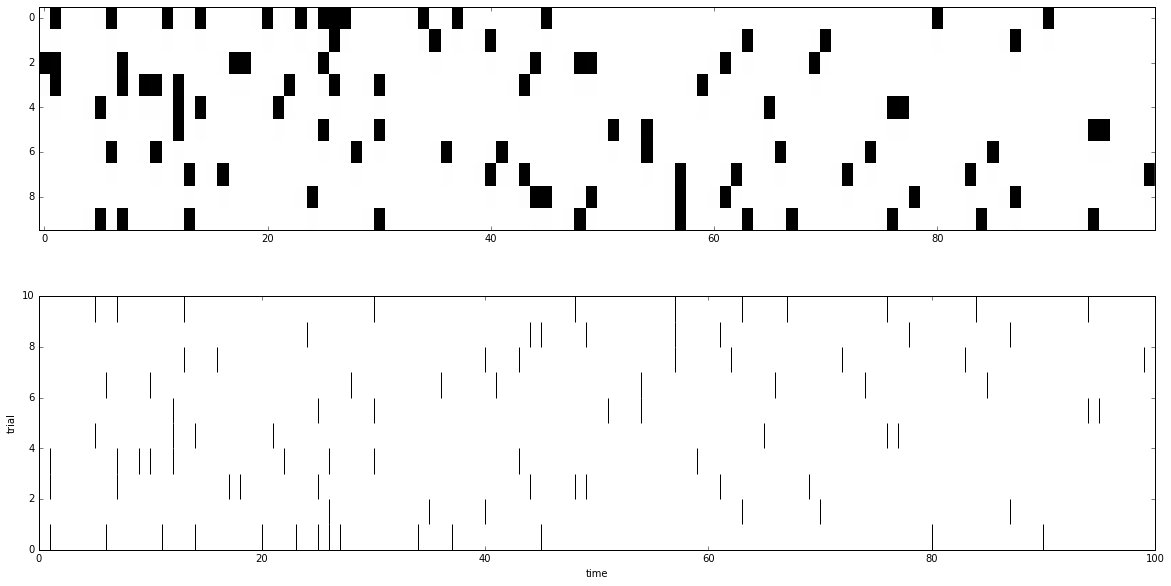

In [6]:
# plotting rasters in two ways
plt.figure(figsize=(20, 10))
plt.subplot(211)
plt.imshow(spike_array,aspect=2,interpolation='none',cmap='Greys')
plt.subplot(212)
plt.vlines(time,neurons,neurons+1)
plt.xlabel('time')
plt.ylabel('trial')
plt.show()

In the cell below, make the raster plots for the data in the array allSpikes (same format as spike_array above)

### Lets make a histogram of average spiking rate

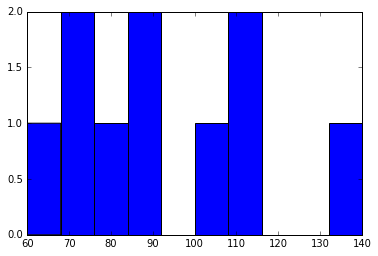

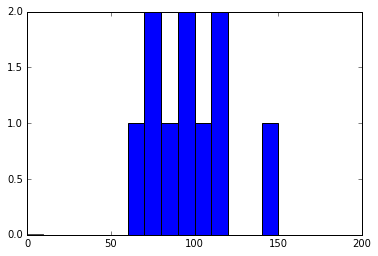

In [7]:
spikes_per_sec = np.mean(spike_array,1)*1000
plt.figure()
plt.hist(spikes_per_sec,bins=10)
plt.show()

plt.figure()
plt.hist(spikes_per_sec,bins=range(0,200,10))
plt.show()

In the cell below. Make a histogram for the allSpikes data. Find a good binsize to get a nice looking plot.

### Let us see how the firing rate of the neurons changes over time

To do this, we will combine every 5 data point into 1 so that we get an average

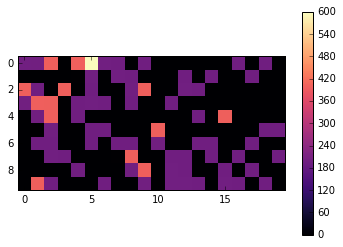

In [10]:
combine_points=5
mean_rate_over_time=np.zeros([spike_array.shape[0],spike_array.shape[1]/combine_points])
for i in range(spike_array.shape[1]/combine_points):
    mean_rate_over_time[:,i]=np.mean(spike_array[:,combine_points*i:combine_points*(i+1)],1)*1000
plt.imshow(mean_rate_over_time,interpolation='none',cmap='magma')
plt.colorbar()
plt.show()


In the cell below, implement this for allSpike data and then see the effect of changing the number of points we combine

### A way to get smoother data is to use filters on the spike train.

Lets use the built in uniform filter to understand what is happening.

In [11]:
unif_filtered=np.zeros(spike_array.shape)
size_of_filter=10
for i in range(spike_array.shape[0]):
    unif_filtered[i,:]=sp.ndimage.filters.uniform_filter1d(spike_array[i,:]*1000,size_of_filter,mode='wrap')

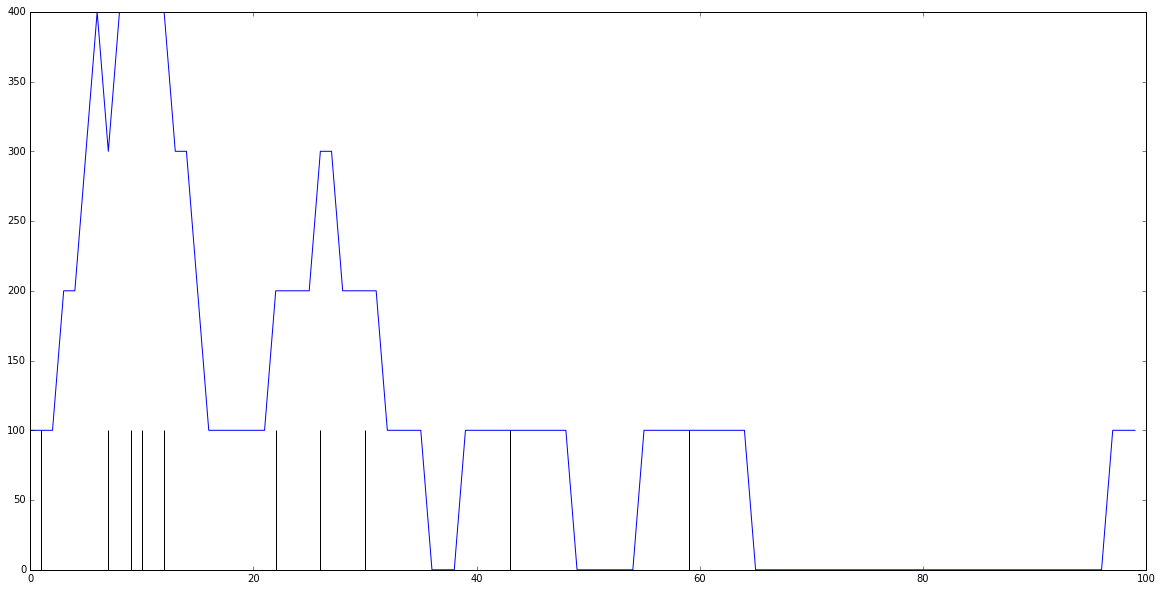

In [12]:
plt.figure(figsize=(20, 10))
i_th_neuron=3
plt.plot(unif_filtered[i_th_neuron,:])
plt.vlines(np.where(spike_array[i_th_neuron,:]==1),0,100)


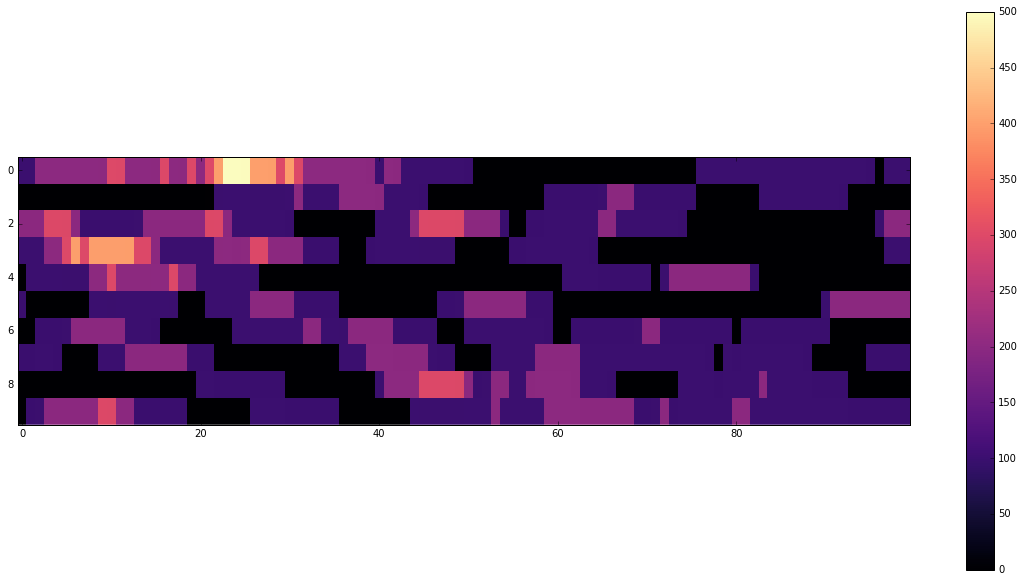

In [15]:
plt.figure(figsize=(20, 10))
plt.imshow(unif_filtered,aspect=3,cmap='magma',interpolation="None")
plt.colorbar()
plt.show()

In the cell below, use the filter for the allSpikes. The instead of 

sp.ndimage.filters.uniform_filter1d 

use

sp.ndimage.filters.gaussian_filter1d . 

Also experiment with what happens when you change filter size.

### Now we will try to use a custom filter instead of the standard ones

First lets make an array which has an exponential shape. This array will be used as the filter.

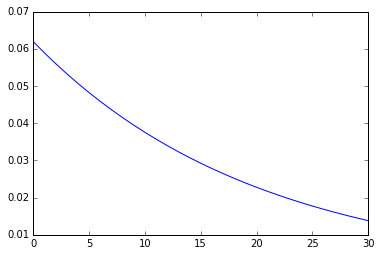

In [16]:
filter_size=31   #use odd number
filter_exp= scipy.signal.exponential(filter_size, center=0, tau=20.0,sym=False) #standard function
filter_exp=filter_exp/sum(filter_exp) #normalize the filter so that its area is 1
plt.plot(filter_exp)
plt.show()

In [17]:
exp_filtered=np.zeros(spike_array.shape)
for i in range(spike_array.shape[0]):
    exp_filtered[i,:]=sp.ndimage.filters.convolve1d(spike_array[i,:]*1000,filter_exp,mode='constant',origin=(-1*filter_size-1)/2)

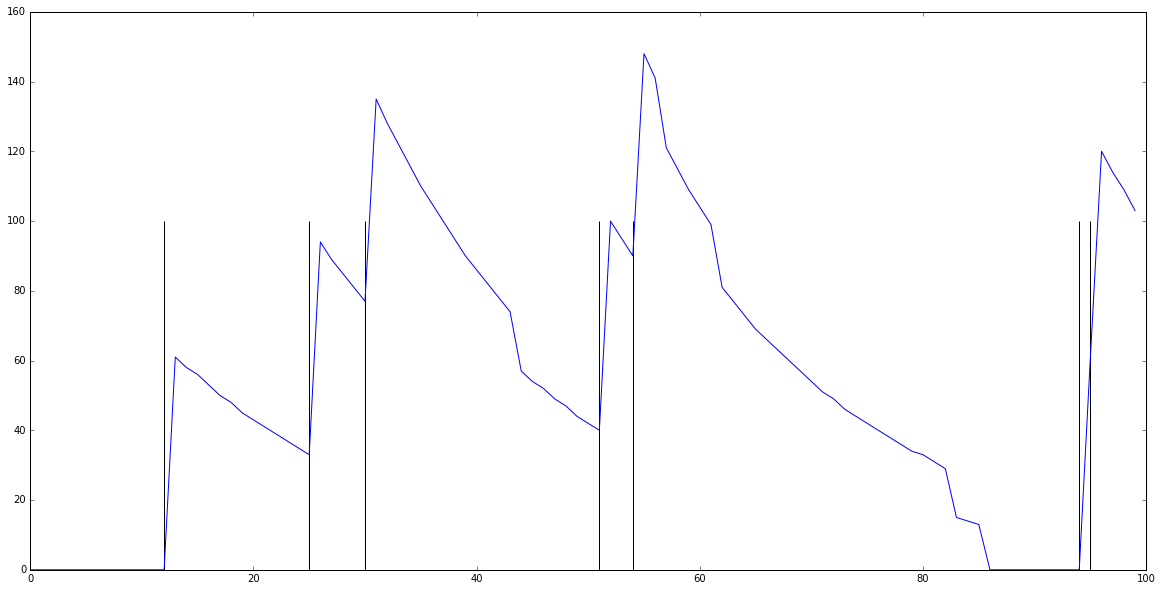

In [21]:
plt.figure(figsize=(20, 10))
i_th_neuron=5
plt.plot(exp_filtered[i_th_neuron,:])
plt.vlines(np.where(spike_array[i_th_neuron,:]==1),0,100)
plt.show()

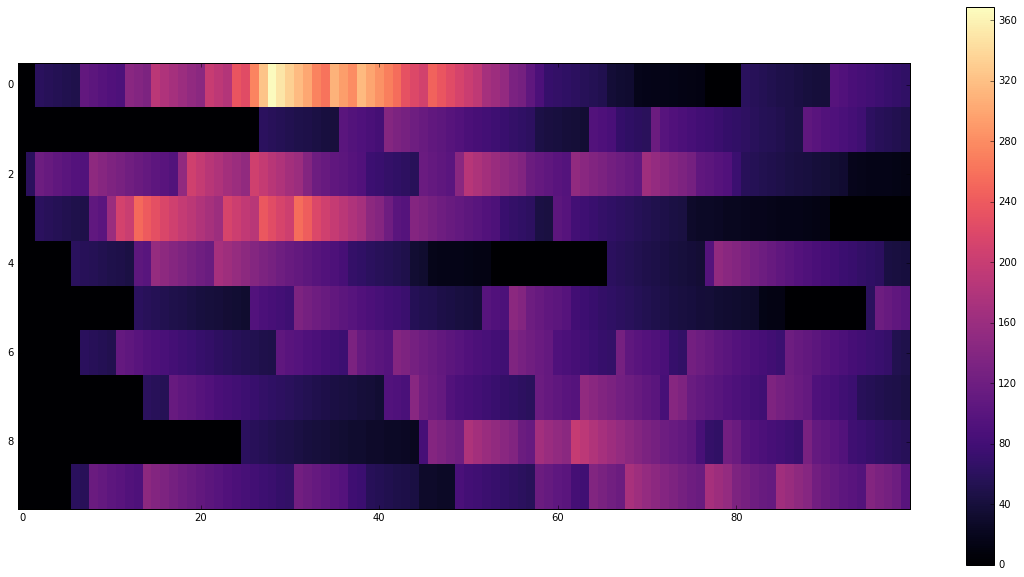

In [22]:
plt.figure(figsize=(20, 10))
plt.imshow(exp_filtered,aspect=5,cmap='magma',interpolation="None")
plt.colorbar()
plt.show()

In the cell below, implement this for allSpikes data. Then try to change the size of the filter and the tau of the filter.



Now, in the cell below, try to use a tringular filter using sp.signal.triang(filter_size) function instead of the scipy.signal.exponential(filter_size, center=0, tau=20.0,sym=False)

## PSTH

Lets make peristimulus histogram. To do this, just find all the times at which neurons spike. The plot a histogram of those.



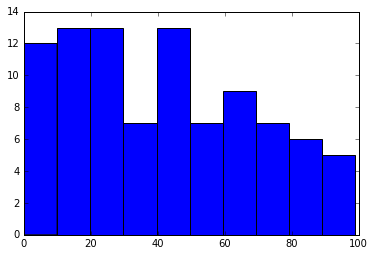

In [23]:
neurons,time=np.where(spike_array==1)
plt.hist(time,bins=10)
plt.show()

In the cell below, do the same for allSpikedata

# Machine learning

Now that we have done some basic analysis on spike train data, lets do some Machine learning.

### We will start with K-Means clustering of data

In [24]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

n_samples = 150
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

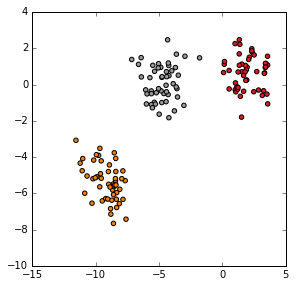

In [27]:
# Incorrect number of clusters

km=KMeans(n_clusters=3, random_state=random_state)
y_pred = km.fit_predict(X)
labels=km.labels_
cluster_centers=km.cluster_centers_

        
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred,cmap='Set1')

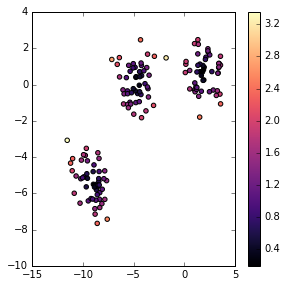

In [28]:
def calc_dist(labels,X,cluster_centers):
    Y=np.zeros(X.shape[0])
    for i,j in enumerate(labels):
        Y[i]=np.linalg.norm(X[i,:]-cluster_centers[j])
#     print Y
    return Y

dist = calc_dist(labels,X,cluster_centers)
plt.figure(figsize=(10, 10))
plt.subplot(222)
plt.scatter(X[:, 0], X[:, 1], c=dist,cmap='magma')
plt.colorbar()